# SIIM-ISIC Melanoma Classification

### Identify melanoma in lesion images

## Description

### **SIIM**


>The Society for Imaging Informatics in Medicine (SIIM) is the leading healthcare professional organization for those interested in the current and future use of informatics in medical imaging. The society's mission is to advance medical imaging informatics across the enterprise through education, research, and innovation in a multi-disciplinary community

### **ISIC :**

>The International Skin Imaging Collaboration: Melanoma Project is an academia and industry partnership designed to facilitate the application of digital skin imaging to help reduce melanoma mortality. When recognized and treated in its earliest stages, melanoma is readily curable. Digital images of skin lesions can be used to educate professionals and the public in melanoma recognition as well as directly aid in the diagnosis of melanoma through teledermatology, clinical decision support, and automated diagnosis.


### **Skin Cancer :**

>Skin cancer is the most prevalent type of cancer. Melanoma, specifically, is responsible for 75% of skin cancer deaths, despite being the least common skin cancer. The American Cancer Society estimates over 100,000 new melanoma cases will be diagnosed in 2020. It's also expected that almost 7,000 people will die from the disease. As with other cancers, early and accurate detection—potentially aided by data science—can make treatment more effective.


# **Problem Statement :**

In this workshop , you’ll identify melanoma in images of skin lesions and you’ll use images within the same patient and determine which are likely to represent a melanoma. Using patient-level contextual information may help the development of image analysis tools, which could better support clinical dermatologists.


# **Installing the Libraries**

In [1]:
!pip install -q --upgrade pip
!pip install -q efficientnet

In [2]:
import re
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from functools import partial
import efficientnet.tfkeras as efn
from kaggle_datasets import KaggleDatasets
from sklearn.model_selection import train_test_split

## what is TPU?

Tensor Processing Units (TPUs) are Google's custom-developed application-specific integrated circuits (ASICs) used to accelerate machine learning workloads.It's easy to run replicated models on Cloud TPU using High-level Tensorflow APIs .

TPUs are designed to provide significant speedups over traditional CPUs and GPUs by optimizing the processing of tensor operations, which are the building blocks of deep learning algorithms.


### TPU Performance : 

TPU can achieve a high computational throughput on massive multiplications and additions for neural networks , at blazingly fast speeds with much less power consumption and smaller footprint.


**TPU Initialization:** TPUs  are usually on Cloud TPU workers and hence have to be connected to remote clusters and then initialized .

**Distribution strategies :** A distribution strategy is an abstraction that can be used to drive models on CPU, GPUs or TPUs. 

>Credit : The code has been adapted from @mgornergooglestater kernel on Flower classification on TPUs

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Device:', tpu.master())
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
except:
    strategy = tf.distribute.get_strategy()
print('Number of replicas:', strategy.num_replicas_in_sync)

Device: grpc://10.0.0.2:8470
Number of replicas: 8



> <b>Note:</b> TPUs read data directly from <code>Google Cloud Storage (GCS)</code> This Kaggle utility will copy the dataset to a GCS bucket co-located with the TPU. If you have multiple datasets attached to the notebook, you can pass the name of a specific dataset to the <code>get_gcs_path function</code>. The name of the dataset is the name of the directory it is mounted in. Use <code>!ls /kaggle/input/</code> to list attached datasets.


In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
GCS_PATH = KaggleDatasets().get_gcs_path('siim-isic-melanoma-classification')
BATCH_SIZE = 8 * strategy.num_replicas_in_sync
IMAGE_SIZE = [1024, 1024]

## TF Records :

**What is TF Records ?** 

     TFRecords is a file format used to store large datasets that  efficiently read and process during training of ML models. 

      Improves performance, reduces memory usage, and simplifies data preprocessing and storage.
    
    TF-Record is Tensorflow’s own binary storage format.The key benefits of TFRecords is that it allows for random access to individual records, which is essential when dealing with large datasets that may not fit into memory. 

    Any byte-string that can be decoded in TensorFlow could be stored in a TFRecord file. Examples include: Lines of text, JSON ,encoded image data, or serialized tf.Tensors.

    A TFRecord file contains a sequence of records and can only be read sequentially.Each record contains a byte-string, for the data-payload, plus the data-length, and CRC32C (32-bit CRC using the Castagnoli polynomial) hashes for integrity checking.


## Spliting the train and test filenames.

  Initially import the train_test_split and uses the **tf.io.gfile.glob()** function to get a list of all the  TFRecord files in the specified GCS_PATH directory that match the pattern 'train*.tfrec'. The glob function returns a list of file paths that match the pattern.(done for training data)

    Same process is followed for the testing data.


In [5]:
TRAINING_FILENAMES, VALID_FILENAMES = train_test_split(
    tf.io.gfile.glob(GCS_PATH + '/tfrecords/train*.tfrec'),
    test_size=0.1, random_state=42
)
TEST_FILENAMES = tf.io.gfile.glob(GCS_PATH + '/tfrecords/test*.tfrec')
print('Train TFRecord Files:', len(TRAINING_FILENAMES))
print('Validation TFRecord Files:', len(VALID_FILENAMES))
print('Test TFRecord Files:', len(TEST_FILENAMES))

Train TFRecord Files: 14
Validation TFRecord Files: 2
Test TFRecord Files: 16


### tf.data

**What is tf.data ?**

1. Enables you to build complex input pipelines from simple, reusable pieces.Also makes it possible to handle large amounts of data, read from different data formats, and perform complex transformations.

2. tf.data is a powerful and flexible tool that can help you work with complex datasets and build more efficient and scalable machine learning models.

For example, in an image pipeline, an element might be a single training example, with a pair of tensor components representing the image and its label.


![](https://drive.google.com/uc?id=1CLfEMEn9uiPGjhgVZc620djKmBQrwSZV)

![](https://drive.google.com/uc?id=1x383ghyybTV0jQqBSlHDEc8FWD8AqaHz)


## Image Conversion.

Takes an image as input and returns a tensor representing the image.

1. tf.image.decode_jpeg() function to decode the input image, which is assumed to be in JPEG format, into a tensor with 3 color channels (red, green, and blue). 

2. tf.cast() function to convert the pixel values in the tensor to float32 format, and divides them by 255.0 to normalize the pixel values to the range [0, 1]. 

3. tf.reshape() function to reshape the tensor to the specified IMAGE_SIZE, which is assumed to be a list or tuple of two integers representing the height and width of the image.

In [6]:
def decode_to_tensor(image):
    image = tf.image.decode_jpeg(image, channels=3)
    image = tf.cast(image, tf.float32) / 255.0
    image = tf.reshape(image, [*IMAGE_SIZE, 3])
    return image

## Function to read tfrecord.

This code defines a function called read_tfrecord that takes two arguments: example and labeled. 

example: serialized string
labeled: boolean flag- labeled or unlabeled

1. tfrecord_format specifies the expected format of the TFRecord example. If labeled is True, the dictionary includes a target key with a tf.int64 - False : tf.string

2. tf.io.parse_single_example() function to parse the serialized example into a dictionary with keys that match those in tfrecord_format.

This function is used to read and decode examples from a TFRecord file, and is designed to work with both labeled and unlabeled datasets.

In [7]:
def read_tfrecord(example, labeled):
    tfrecord_format = {
        "image": tf.io.FixedLenFeature([], tf.string),
        "target": tf.io.FixedLenFeature([], tf.int64)
    } if labeled else {
        "image": tf.io.FixedLenFeature([], tf.string),
        "image_name": tf.io.FixedLenFeature([], tf.string)
    }
    example = tf.io.parse_single_example(example, tfrecord_format)
    image = decode_to_tensor(example['image'])
    if labeled:
        label = tf.cast(example['target'], tf.int32)
        return image, label
    idnum = example['image_name']
    return image, idnum

**Input Pipeline :**

 tf.data.TFRecordDataset() is used to create an input pipeline for data stored in TFRecord format .
 
 To create a TFRecordDataset object, you simply pass one or more file paths to the constructor. 
 
 tf.data module that is used to create a dataset from one or more TFRecord files. 
 
#### In single stretch.
 Once you have created a TFRecordDataset, you can use it to iterate over the examples in the dataset. For example, you can use the map() function to apply a function to each example in the dataset, and the batch() function to group examples into batches:



In [8]:
def load_dataset(filenames, labeled=True, ordered=False):
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False # disable order, increase speed
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads=AUTOTUNE) # automatically interleaves reads from multiple files
    dataset = dataset.with_options(ignore_order) # uses data as soon as it streams in, rather than in its original order
    dataset = dataset.map(partial(read_tfrecord, labeled=labeled), num_parallel_calls=AUTOTUNE)
    # returns a dataset of (image, label) pairs if labeled=True or (image, id) pairs if labeled=False
    return dataset

## Data Augmentation :

Data augmentation is a technique through which one can increase the size of the data for the training of the model without adding the new data. Techniques like padding, cropping, rotating, and flipping are the most common methods that are used over the images to increase the data size. 


<b>Note:</b> Both <code>Keras Preprocessing Layers</code> and <code>tf.image</code> can be used for data augmentation. For finer control , <code>tf.image</code> is preferred.



![](https://drive.google.com/uc?id=1_uGNygnCZ--G_hOP7zEr_oscGjvnBnob)



In [9]:
def augmentation_pipeline(image, label):
    image = tf.image.random_flip_left_right(image)
    return image, label

 ### **Transformations :**

The Dataset object can be transformed into a new Dataset by chaining method calls on the tf.data.Dataset object . Some of the transformations which can be applied are Dataset.map() , Dataset.batch() , Dataset.shuffle() , Dataset.prefetch() .

The Dataset object is a Python iterable which  it possible to consume its elements using a for loop .


#### Transformation to training dataset.

>**shuffle()** - to shuffle the elements with a buffer size of 2048

By shuffling the elements before batching them, you can ensure that each batch contains a random sample of elements from the dataset, which can help to reduce overfitting and improve the generalization performance of your model.

>**buffer size** refers to the number of elements that are buffered and available for shuffling or prefetching during dataset iteration.In general, a larger buffer size will result in a better shuffle or faster data loading

Buffer size depend on:
1. size of your dataset.
2. memory available on your system.
3. specific requirements of ML pipeline



In [10]:
def get_training_dataset():
    dataset = load_dataset(TRAINING_FILENAMES, labeled=True)
    dataset = dataset.map(augmentation_pipeline, num_parallel_calls=AUTOTUNE)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

#### Transformation to validation dataset.

>**cache()** stores the elements of the dataset in memory or on disk after they are loaded for the first time.

>**cache()** is a powerful tool for improving the performance of your ML pipelines, and can help you reduce the time it takes to load and preprocess data.


In [ ]:
def get_validation_dataset(ordered=False):
    dataset = load_dataset(VALID_FILENAMES, labeled=True, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.cache()
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

#### Transformation to testing dataset.

>**prefetch()** is a powerful tool for improving the efficiency of your machine learning pipelines 

        Also significantly reduce the amount of time spent waiting for data to be loaded into memory, and improve the overall training performance of your model.

 >**buffer_size** specifies the number of examples to prefetch. You can set this to tf.data.AUTOTUNE to dynamically adjust the prefetch buffer size based on available system memory.

In [12]:
def get_test_dataset(ordered=False):
    dataset = load_dataset(TEST_FILENAMES, labeled=False, ordered=ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTOTUNE)
    return dataset

## Count the data Items.

count_data_items function calculates the total number of data items in a set of files 

In [13]:
def count_data_items(filenames):
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

In [14]:
NUM_TRAINING_IMAGES = count_data_items(TRAINING_FILENAMES)
NUM_VALIDATION_IMAGES = count_data_items(VALID_FILENAMES)
NUM_TEST_IMAGES = count_data_items(TEST_FILENAMES)
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
print(
    'Dataset: {} training images, {} validation images, {} unlabeled test images'.format(
        NUM_TRAINING_IMAGES, NUM_VALIDATION_IMAGES, NUM_TEST_IMAGES
    )
)

Dataset: 28984 training images, 4142 validation images, 10982 unlabeled test images


### **Cyclic learning rates :**


>Cyclic learning rates  is a learning rate scheduling technique for 
(1) faster training of a network and 
(2) a finer understanding of the optimal learning rate. 

>Cyclic learning rates have an effect on the model training process known somewhat fancifully as<code>"superconvergence"</code> 




![](https://drive.google.com/uc?id=1bnsglJByd1lc1h9hGrz2WZa1LzVBgtWW)

Image Source : https://arxiv.org/abs/1803.09820

In [15]:
def build_lrfn(lr_start=0.00001, lr_max=0.000075, lr_min=0.000001, lr_rampup_epochs=20, lr_sustain_epochs=0, lr_exp_decay=.8):
    lr_max = lr_max * strategy.num_replicas_in_sync
    def lrfn(epoch):
        if epoch < lr_rampup_epochs:
            lr = (lr_max - lr_start) / lr_rampup_epochs * epoch + lr_start
        elif epoch < lr_rampup_epochs + lr_sustain_epochs:
            lr = lr_max
        else:
            lr = (lr_max - lr_min) * lr_exp_decay ** (epoch - lr_rampup_epochs - lr_sustain_epochs) + lr_min
        return lr
    return lrfn

# EfficientNets

**Idea Of EfficientNets:**
     EfficientNets are a promising family of deep neural network architectures that achieve state-of-the-art performance on image classification tasks with fewer resources, which makes them more accessible to a wider range of applications and use cases.


**Compound Model Scaling: A Better Way to Scale Up CNNs**

EfficientNets uses a new scaling method that uniformly scales all dimensions of depth/width/resolution using a simple yet highly effective compound coefficient The first step in the compound scaling method is to perform a grid search to find the relationship between different scaling dimensions of the baseline network under a fixed resource constraint.This determines the appropriate scaling coefficient for each of the dimensions mentioned above. We then apply those coefficients to scale up the baseline network to the desired target model size or computational budget.

This compound scaling method consistently improves model accuracy and efficiency for scaling up existing models such as MobileNet (+1.4% imagenet accuracy), and ResNet (+0.7%), compared to conventional scaling methods.



![](https://drive.google.com/uc?id=18ZzZw0U-4O4iPe1JBVZwUVcn4FCmTS_x)

**EfficientNet Architecture :**

The effectiveness of model scaling also relies heavily on the baseline network which  is developed by performing a neural architecture search using the AutoML MNAS framework, which optimizes both accuracy and efficiency (FLOPS). The resulting architecture uses mobile inverted bottleneck convolution (MBConv), similar to MobileNetV2 and MnasNet, but is slightly larger due to an increased FLOP budget.The baseline network is then scaled up to obtain a family of models, called EfficientNets.

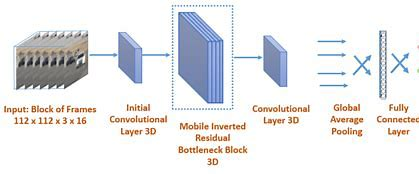

 **EfficientNet Performance**


The EfficientNet models achieve both higher accuracy and better efficiency over existing CNNs like ResNet , DenseNet etc , reducing parameter size and FLOPS by an order of magnitude. 


![](https://drive.google.com/uc?id=1jYu8AMPI9LVF2TQKUgJyKZaZqpsm3U0k)



## Model summary

1. Getting the dataset
2. Building the efficientNet model
3. Compiling the model.

**1. Getting the dataset:**
    Defining the dataset as train and validation.

**2. Building the efficientNet model**

   >**tf.keras.Sequential** model that uses the EfficientNetB6 convolutional neural network (CNN) architecture pre-trained on the ImageNet dataset.
        
   >**efn.EfficientNetB6** function creates an instance of the EfficientNetB6 model with the specified input shape((*IMAGE_SIZE, 3)),which specifies the height, width, and number of channels of the input images.
      
   >**weights='imagenet'**, which means that the pre-trained weights for the EfficientNetB6 model will be downloaded and used as the initial weights for the model.
     
   >**include_top argument** is set to False, which means that the top (classification) layer of the model will be excluded from the architecture. 
     

**3. Constructing the layers.**

   Under layering  we have used GlobalAveragePooling2D,Dropout,Dense
    
   >**GlobalAveragePooling** - computes the average value of each feature map in the output of the previous layer, resulting in a single value for each feature map. This operation reduces the number of parameters in the model and makes it more computationally efficient.

  > **Droupout** - randomly sets a fraction of the input units to zero during training, which helps to prevent overfitting by reducing the capacity of the model.
    
  > **Dense Layer** - fully connected layer with 512 units and a rectified linear unit (ReLU) activation function. This layer processes the output of the global average pooling layer and learns a high-level representation of the features.
    
    
**4. Compliling the model**

   >**'adam'** is an adaptive learning rate optimization algorithm used in deep learning. The Adam optimizer adjusts the learning rate for each parameter based on the historical gradient information, which makes it more robust to noisy gradients and helps to converge faster.
       
   >**'binary_crossentropy'** is the loss function for binary classification problems. This loss function measures the difference between the predicted probability and the actual label for each example in the training data.The goal of the model during training is to minimize this loss function.
      
   >**['accuracy']** is the evaluation metric used to monitor the performance of the model during training and testing. The accuracy metric measures the proportion of examples that are classified correctly by the model.
    
    
        

In [16]:
with strategy.scope():
    
    train_dataset = get_training_dataset()
    valid_dataset = get_validation_dataset()
    
    model = tf.keras.Sequential([
        efn.EfficientNetB6(
            input_shape=(*IMAGE_SIZE, 3),
            weights='imagenet',
            include_top=False
        ),
        tf.keras.layers.GlobalAveragePooling2D(),
        tf.keras.layers.Dense(512, activation= 'relu'), 
        tf.keras.layers.Dropout(0.25), 
        tf.keras.layers.Dense(1, activation='sigmoid')
    ])
    
    model.compile(
        optimizer='adam',
        loss = 'binary_crossentropy',
        metrics=['accuracy']
    )

model.summary()

165527552/165527152 [==============================] - 2s 0us/step
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnet-b6 (Functional) (None, 32, 32, 2304)      40960136  
_________________________________________________________________
global_average_pooling2d (Gl (None, 2304)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               1180160   
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 42,140,809
Trainable params: 41,916,377
Non-trainable params: 224,432
_________________________________________________________________


##  Fitting the model.

1. Adjusting learning rate
2. setting the callbacks.
3. fixing the epoch.

In [17]:
lrfn = build_lrfn()
STEPS_PER_EPOCH = NUM_TRAINING_IMAGES // BATCH_SIZE
VALID_STEPS = NUM_VALIDATION_IMAGES // BATCH_SIZE


history = model.fit(
    train_dataset, epochs=1,
    steps_per_epoch=STEPS_PER_EPOCH,
    validation_data=valid_dataset,
    validation_steps=VALID_STEPS,
    callbacks=[
        tf.keras.callbacks.LearningRateScheduler(lrfn, verbose=1),
        tf.keras.callbacks.ModelCheckpoint(
            os.path.join("./model.h5"),
            monitor='train_loss', verbose=0,
            save_best_only=True, save_weights_only=False,
            mode='auto', save_freq='epoch'
        )
    ]
)


Epoch 00001: LearningRateScheduler reducing learning rate to 1e-05.
452/452 [==============================] - 846s 2s/step - loss: 0.3428 - accuracy: 0.9134 - val_loss: 0.1301 - val_accuracy: 0.9775


## Result ( training dataset).

In [18]:
sub = pd.read_csv('/kaggle/input/siim-isic-melanoma-classification/sample_submission.csv')
sub.head()

,image_name,target
0,ISIC_0052060,0
1,ISIC_0052349,0
2,ISIC_0058510,0
3,ISIC_0073313,0
4,ISIC_0073502,0


## Handling the test dataset.

First, we get the test dataset test_ds by calling the get_test_dataset function.

Next, we create a new dataset test_images_ds by mapping the test_ds dataset to only return the images (without the ID numbers). This is because the model.predict() method expects a dataset of images as input.

model.predict() method to compute the predicted probabilities for each image in the test_images_ds dataset. 



In [19]:
test_ds = get_test_dataset(ordered=True)

print('Computing predictions...')
test_images_ds = test_ds.map(lambda image, idnum: image)
probabilities = model.predict(test_images_ds)

Computing predictions...


## Generating the submission file.

we use the **unbatch()** method to convert the dataset of ID numbers into a flat dataset of individual ID numbers.

we use the **next()** function to get the next batch of ID numbers from the test_ids_ds dataset. 

We pass the argument 
**iter(test_ids_ds.batch(NUM_TEST_IMAGES))** to the next() function to ensure that we only get the first batch of ID numbers, where NUM_TEST_IMAGES is the number of test images in the test dataset.

we convert the resulting batch of ID numbers to a numpy array of strings with the **astype('U')** method. These strings represent the ID numbers of the test images and will be used to create the submission file.

In [20]:
print('Generating submission.csv file...')
test_ids_ds = test_ds.map(lambda image, idnum: idnum).unbatch()
test_ids = next(iter(test_ids_ds.batch(NUM_TEST_IMAGES))).numpy().astype('U')

Generating submission.csv file...


## Creating the prediction dataframe 

In [21]:
pred_df = pd.DataFrame({'image_name': test_ids, 'target': np.concatenate(probabilities)})
pred_df.head()

,image_name,target
0,ISIC_6381819,0.019907
1,ISIC_5583376,0.017218
2,ISIC_6408546,0.020971
3,ISIC_6932354,0.195981
4,ISIC_8191278,0.012761



## Result (testing data)

#### **Submission.CSV**

Deleting the target column from the sub dataframe. 

Merging the sub dataframe with the pred_df dataframe using the image_name column as the join key. The resulting merged dataframe contains the predicted probabilities for each test image.

Saving the merged dataframe as a CSV file named submission.csv using the to_csv() method. We pass the argument index=False to the to_csv() method to exclude the index column from the CSV file.


In [22]:
del sub['target']
sub = sub.merge(pred_df, on='image_name')
sub.to_csv('submission.csv', index=False)
sub.head()

,image_name,target
0,ISIC_0052060,0.145588
1,ISIC_0052349,0.128266
2,ISIC_0058510,0.057062
3,ISIC_0073313,0.015582
4,ISIC_0073502,0.017009


# References :

https://www.kaggle.com/mgornergoogle/getting-started-with-100-flowers-on-tpu

https://www.tensorflow.org/tutorials/load_data/tfrecord

https://cloud.google.com/tpu

https://www.tensorflow.org/guide/tpu

https://www.tensorflow.org/tutorials/images/data_augmentation

https://ai.googleblog.com/2019/05/efficientnet-improving-accuracy-and.html

